In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier

from skopt import BayesSearchCV

from xgboost import XGBClassifier

import pickle

%matplotlib inline

In [172]:
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

In [66]:
!ls data

aac_intakes.csv          df_dog.csv               master12218.csv
aac_intakes_outcomes.csv df_mod.csv               master_df.csv
aac_outcomes.csv         engineered.csv           master_df_1128.csv
all_categoricals.csv     group_shade.csv          master_df_1129.csv
concat_backup.csv        hour_ids.csv             model12218.csv
df_cat.csv               hr_name.csv


In [89]:
df_raw = pd.read_csv('./data/master12218.csv', index_col=0)

In [90]:
df_raw['datetime_in'] = pd.to_datetime(df_raw['datetime_in'])

In [91]:
df_raw['hour'] = df_raw['datetime_in'].dt.hour + (df_raw['datetime_in'].dt.minute/60.0)

In [92]:
df_raw = df_raw[~df_raw.duplicated()]

In [126]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64906 entries, 0 to 75010
Data columns (total 19 columns):
age                 64906 non-null int64
animal_type         64906 non-null object
days_in_shelter     64906 non-null int64
dow                 64906 non-null int64
fixed_status        64906 non-null object
gender              64906 non-null int64
group               64906 non-null object
intake_condition    64906 non-null object
intake_season       64906 non-null object
intake_type         64906 non-null object
mix                 64906 non-null int64
name                64906 non-null int64
outcome_type        64696 non-null object
simple_color        64906 non-null object
simple_group        64906 non-null object
shade               64906 non-null object
given_name          47196 non-null object
name_freq           64906 non-null int64
hour                64906 non-null float64
dtypes: float64(1), int64(7), object(11)
memory usage: 9.9+ MB


In [94]:
df_raw.drop(labels=['animal_id', 'datetime_in', 'hour_in'], axis=1, inplace=True)

In [95]:
df_raw.drop_duplicates(inplace=True)

In [118]:
df_raw.outcome_type.value_counts()

Adoption           29197
Transfer           20117
Return to Owner    12067
Euthanasia          2788
Died                 527
Rto-Adopt            147
Missing               41
Disposal              22
Name: outcome_type, dtype: int64

In [119]:
df_raw = df_raw[df_raw != 'Rto-Adopt']
df_raw = df_raw[df_raw != 'Missing']
df_raw = df_raw[df_raw != 'Disposal']

In [96]:
df = pd.read_csv('./data/model12218.csv', index_col = 0)

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64339 entries, 0 to 75010
Data columns (total 18 columns):
age                 64339 non-null int64
animal_type         64339 non-null object
dow                 64339 non-null int64
fixed_status        64339 non-null object
gender              64339 non-null int64
group               64339 non-null object
intake_condition    64339 non-null object
intake_season       64339 non-null object
intake_type         64339 non-null object
mix                 64339 non-null int64
simple_color        64339 non-null object
hour_in             64339 non-null int64
simple_group        64339 non-null object
shade               64339 non-null object
given_name          47018 non-null object
name_freq           64339 non-null int64
days_in_shelter     64339 non-null int64
outcome_type        64339 non-null object
dtypes: int64(7), object(11)
memory usage: 9.3+ MB


In [98]:
df['gender'] = df['gender'].astype(str)

In [99]:
df['dow'] = df['dow'].astype(str)
df['mix'] = df['mix'].astype(str)
df['hour_in'] = df['hour_in'].astype(str)

In [100]:
df = df.drop(labels=['days_in_shelter'], axis=1)

In [101]:
df = df[~df.duplicated()]

In [102]:
df.reset_index(inplace=True, drop=True)

In [161]:
def reduce_response(x):
    if x == 'Adoption':
        return x
    else:
        return 'Not Adoption'

In [163]:
df['outcome_type'] = df['outcome_type'].apply(lambda x: reduce_response(x))

Normal      56596
Injured      3069
Sick         2002
Nursing      1423
Aged          293
Other         130
Feral          85
Pregnant       44

In [220]:
df = df[df['intake_condition'] != 'Aged']
df = df[df['intake_condition'] != 'Other']
df = df[df['intake_condition'] != 'Feral']
df = df[df['intake_condition'] != 'Pregnant']

In [226]:
df = df[df['intake_type'] != 'Euthanasia Request']

In [225]:
df['intake_type'].value_counts()

Stray                 47279
Owner Surrender       11660
Public Assist          3962
Euthanasia Request      189
Name: intake_type, dtype: int64

In [229]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [230]:
X = X.drop(labels=['given_name'], axis=1)

In [231]:
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [168]:
X.head()

,age,animal_type,dow,fixed_status,gender,group,intake_condition,intake_season,intake_type,mix,simple_color,hour_in,simple_group,shade,name_freq
0,2920,Dog,6,fixed,1,Sporting,Normal,summer,Stray,0,White,12,Sporting,Light,52
1,330,Dog,3,intact,0,Hound,Normal,spring,Stray,1,Sable,18,Non-Sporting,Light,1
2,1460,Dog,6,fixed,0,Working,Normal,spring,Stray,1,Yellow,10,Non-Sporting,Light,22
3,730,Dog,5,fixed,0,Sporting,Normal,winter,Owner Surrender,1,Brown,12,Sporting,Medium,32
4,730,Dog,3,intact,0,Sporting,Normal,summer,Public Assist,1,Black,14,Sporting,Dark,1


In [173]:
cat = CatBoostClassifier(cat_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

tuning_params = {'one_hot_max_size': [24], 'learning_rate': [1e-2, 1], 'loss_function': ['MultiClass'],
                 'depth': [6, 10], 'n_estimators': [800], 'l2_leaf_reg': [1e-2, 1e-1, 1]}


bs = BayesSearchCV(cat, tuning_params, cv=3, verbose=True, scoring='neg_log_loss', n_jobs=-1, n_iter=10)

bs.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min finished


0:	learn: -0.6714402	total: 109ms	remaining: 1m 27s
1:	learn: -0.6537105	total: 216ms	remaining: 1m 26s
2:	learn: -0.6392345	total: 332ms	remaining: 1m 28s
3:	learn: -0.6273146	total: 441ms	remaining: 1m 27s
4:	learn: -0.6173446	total: 547ms	remaining: 1m 26s
5:	learn: -0.6097443	total: 659ms	remaining: 1m 27s
6:	learn: -0.6031818	total: 765ms	remaining: 1m 26s
7:	learn: -0.5963570	total: 876ms	remaining: 1m 26s
8:	learn: -0.5907892	total: 960ms	remaining: 1m 24s
9:	learn: -0.5864528	total: 1.07s	remaining: 1m 24s
10:	learn: -0.5824509	total: 1.18s	remaining: 1m 24s
11:	learn: -0.5795421	total: 1.29s	remaining: 1m 24s
12:	learn: -0.5760747	total: 1.4s	remaining: 1m 24s
13:	learn: -0.5731296	total: 1.5s	remaining: 1m 24s
14:	learn: -0.5706347	total: 1.61s	remaining: 1m 24s
15:	learn: -0.5679874	total: 1.73s	remaining: 1m 24s
16:	learn: -0.5670839	total: 1.81s	remaining: 1m 23s
17:	learn: -0.5655447	total: 1.93s	remaining: 1m 23s
18:	learn: -0.5644277	total: 2.02s	remaining: 1m 22s
19:	l

157:	learn: -0.5333343	total: 15.2s	remaining: 1m 1s
158:	learn: -0.5332248	total: 15.3s	remaining: 1m 1s
159:	learn: -0.5329206	total: 15.4s	remaining: 1m 1s
160:	learn: -0.5328110	total: 15.5s	remaining: 1m 1s
161:	learn: -0.5327843	total: 15.6s	remaining: 1m 1s
162:	learn: -0.5326555	total: 15.7s	remaining: 1m 1s
163:	learn: -0.5325931	total: 15.8s	remaining: 1m 1s
164:	learn: -0.5323147	total: 15.9s	remaining: 1m 1s
165:	learn: -0.5321447	total: 16s	remaining: 1m 1s
166:	learn: -0.5319801	total: 16.1s	remaining: 1m 1s
167:	learn: -0.5317622	total: 16.2s	remaining: 1m 1s
168:	learn: -0.5315346	total: 16.3s	remaining: 1m 1s
169:	learn: -0.5313585	total: 16.4s	remaining: 1m
170:	learn: -0.5308385	total: 16.6s	remaining: 1m
171:	learn: -0.5307931	total: 16.7s	remaining: 1m
172:	learn: -0.5305850	total: 16.8s	remaining: 1m
173:	learn: -0.5305375	total: 16.9s	remaining: 1m
174:	learn: -0.5303530	total: 17s	remaining: 1m
175:	learn: -0.5302130	total: 17.1s	remaining: 1m
176:	learn: -0.530

315:	learn: -0.5155590	total: 32.4s	remaining: 49.5s
316:	learn: -0.5154826	total: 32.5s	remaining: 49.5s
317:	learn: -0.5152991	total: 32.6s	remaining: 49.4s
318:	learn: -0.5151571	total: 32.7s	remaining: 49.3s
319:	learn: -0.5151294	total: 32.8s	remaining: 49.2s
320:	learn: -0.5150882	total: 32.9s	remaining: 49.1s
321:	learn: -0.5149551	total: 33s	remaining: 49s
322:	learn: -0.5148481	total: 33.1s	remaining: 48.9s
323:	learn: -0.5148116	total: 33.2s	remaining: 48.8s
324:	learn: -0.5147141	total: 33.4s	remaining: 48.7s
325:	learn: -0.5144567	total: 33.5s	remaining: 48.7s
326:	learn: -0.5143484	total: 33.6s	remaining: 48.6s
327:	learn: -0.5142905	total: 33.7s	remaining: 48.5s
328:	learn: -0.5141504	total: 33.8s	remaining: 48.4s
329:	learn: -0.5140748	total: 33.9s	remaining: 48.3s
330:	learn: -0.5139684	total: 34s	remaining: 48.2s
331:	learn: -0.5138990	total: 34.2s	remaining: 48.2s
332:	learn: -0.5137957	total: 34.3s	remaining: 48.1s
333:	learn: -0.5136675	total: 34.4s	remaining: 48s
3

472:	learn: -0.5048446	total: 49.4s	remaining: 34.1s
473:	learn: -0.5047788	total: 49.5s	remaining: 34s
474:	learn: -0.5047135	total: 49.6s	remaining: 33.9s
475:	learn: -0.5047129	total: 49.7s	remaining: 33.8s
476:	learn: -0.5046579	total: 49.8s	remaining: 33.7s
477:	learn: -0.5046072	total: 49.9s	remaining: 33.6s
478:	learn: -0.5046072	total: 50s	remaining: 33.5s
479:	learn: -0.5044461	total: 50.1s	remaining: 33.4s
480:	learn: -0.5043356	total: 50.2s	remaining: 33.3s
481:	learn: -0.5042469	total: 50.3s	remaining: 33.2s
482:	learn: -0.5042462	total: 50.4s	remaining: 33.1s
483:	learn: -0.5042058	total: 50.5s	remaining: 33s
484:	learn: -0.5041628	total: 50.6s	remaining: 32.9s
485:	learn: -0.5041066	total: 50.7s	remaining: 32.8s
486:	learn: -0.5040029	total: 50.9s	remaining: 32.7s
487:	learn: -0.5039998	total: 50.9s	remaining: 32.6s
488:	learn: -0.5039340	total: 51s	remaining: 32.5s
489:	learn: -0.5039328	total: 51.1s	remaining: 32.3s
490:	learn: -0.5038549	total: 51.2s	remaining: 32.2s
4

629:	learn: -0.4967811	total: 1m 5s	remaining: 17.8s
630:	learn: -0.4967778	total: 1m 5s	remaining: 17.7s
631:	learn: -0.4967777	total: 1m 5s	remaining: 17.5s
632:	learn: -0.4965791	total: 1m 6s	remaining: 17.4s
633:	learn: -0.4965729	total: 1m 6s	remaining: 17.3s
634:	learn: -0.4965728	total: 1m 6s	remaining: 17.2s
635:	learn: -0.4964785	total: 1m 6s	remaining: 17.1s
636:	learn: -0.4964361	total: 1m 6s	remaining: 17s
637:	learn: -0.4964348	total: 1m 6s	remaining: 16.9s
638:	learn: -0.4964316	total: 1m 6s	remaining: 16.8s
639:	learn: -0.4964315	total: 1m 6s	remaining: 16.7s
640:	learn: -0.4963825	total: 1m 7s	remaining: 16.6s
641:	learn: -0.4962436	total: 1m 7s	remaining: 16.5s
642:	learn: -0.4962344	total: 1m 7s	remaining: 16.4s
643:	learn: -0.4960452	total: 1m 7s	remaining: 16.3s
644:	learn: -0.4959464	total: 1m 7s	remaining: 16.2s
645:	learn: -0.4959451	total: 1m 7s	remaining: 16.1s
646:	learn: -0.4959418	total: 1m 7s	remaining: 16s
647:	learn: -0.4959416	total: 1m 7s	remaining: 15.

784:	learn: -0.4906575	total: 1m 22s	remaining: 1.58s
785:	learn: -0.4906455	total: 1m 22s	remaining: 1.47s
786:	learn: -0.4906336	total: 1m 22s	remaining: 1.37s
787:	learn: -0.4906331	total: 1m 22s	remaining: 1.26s
788:	learn: -0.4905990	total: 1m 23s	remaining: 1.16s
789:	learn: -0.4905724	total: 1m 23s	remaining: 1.05s
790:	learn: -0.4904994	total: 1m 23s	remaining: 947ms
791:	learn: -0.4904985	total: 1m 23s	remaining: 842ms
792:	learn: -0.4903199	total: 1m 23s	remaining: 737ms
793:	learn: -0.4903020	total: 1m 23s	remaining: 632ms
794:	learn: -0.4903019	total: 1m 23s	remaining: 526ms
795:	learn: -0.4903019	total: 1m 23s	remaining: 421ms
796:	learn: -0.4903018	total: 1m 23s	remaining: 315ms
797:	learn: -0.4902885	total: 1m 23s	remaining: 210ms
798:	learn: -0.4902269	total: 1m 24s	remaining: 105ms
799:	learn: -0.4901170	total: 1m 24s	remaining: 0us


BayesSearchCV(cv=3, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x12cb0fb70>,
       fit_params=None, iid=True, n_iter=10, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='neg_log_loss',
       search_spaces={'one_hot_max_size': [24], 'learning_rate': [0.01, 1], 'loss_function': ['MultiClass'], 'depth': [6, 10], 'n_estimators': [800], 'l2_leaf_reg': [0.01, 0.1, 1]},
       verbose=True)

In [174]:
bs.best_score_

-0.5500071240407529

In [175]:
bs.best_params_

{'depth': 9,
 'l2_leaf_reg': 1,
 'learning_rate': 0.10300050558251683,
 'loss_function': 'MultiClass',
 'n_estimators': 800,
 'one_hot_max_size': 24}

In [184]:
cat_boost = CatBoostClassifier(cat_features=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                               depth=8, learning_rate = .023, loss_function='MultiClass',
                               n_estimators = 90, one_hot_max_size=24, l2_leaf_reg=1)

scores = cross_val_score(cat_boost, X_train, y_train, cv=3, n_jobs=-1, scoring='neg_log_loss')

In [185]:
scores

array([-0.56663049, -0.56941483, -0.57094245])

In [186]:
cat_boost.fit(X_train, y_train)

0:	learn: -0.6883128	total: 81.8ms	remaining: 7.28s
1:	learn: -0.6837558	total: 164ms	remaining: 7.21s
2:	learn: -0.6791676	total: 247ms	remaining: 7.17s
3:	learn: -0.6748582	total: 337ms	remaining: 7.24s
4:	learn: -0.6710625	total: 428ms	remaining: 7.28s
5:	learn: -0.6670319	total: 514ms	remaining: 7.2s
6:	learn: -0.6630992	total: 606ms	remaining: 7.19s
7:	learn: -0.6594403	total: 689ms	remaining: 7.06s
8:	learn: -0.6558300	total: 771ms	remaining: 6.94s
9:	learn: -0.6523890	total: 870ms	remaining: 6.96s
10:	learn: -0.6494056	total: 956ms	remaining: 6.87s
11:	learn: -0.6462569	total: 1.04s	remaining: 6.78s
12:	learn: -0.6432974	total: 1.13s	remaining: 6.7s
13:	learn: -0.6405752	total: 1.21s	remaining: 6.58s
14:	learn: -0.6379273	total: 1.29s	remaining: 6.46s
15:	learn: -0.6352499	total: 1.38s	remaining: 6.38s
16:	learn: -0.6328321	total: 1.46s	remaining: 6.29s
17:	learn: -0.6303669	total: 1.55s	remaining: 6.21s
18:	learn: -0.6279754	total: 1.64s	remaining: 6.13s
19:	learn: -0.6256709	t

In [195]:
y_preds = cat_boost.predict_proba(X_test)

In [188]:
y_test

array([0, 1, 0, ..., 0, 1, 0])

In [197]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [193]:
y_test.shape[0]

(15911,)

In [196]:
log_loss(y_test, y_preds)

0.5662281913395384

In [140]:
pickle.dump(cat_boost, open('cat_model.pkl', 'wb'))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

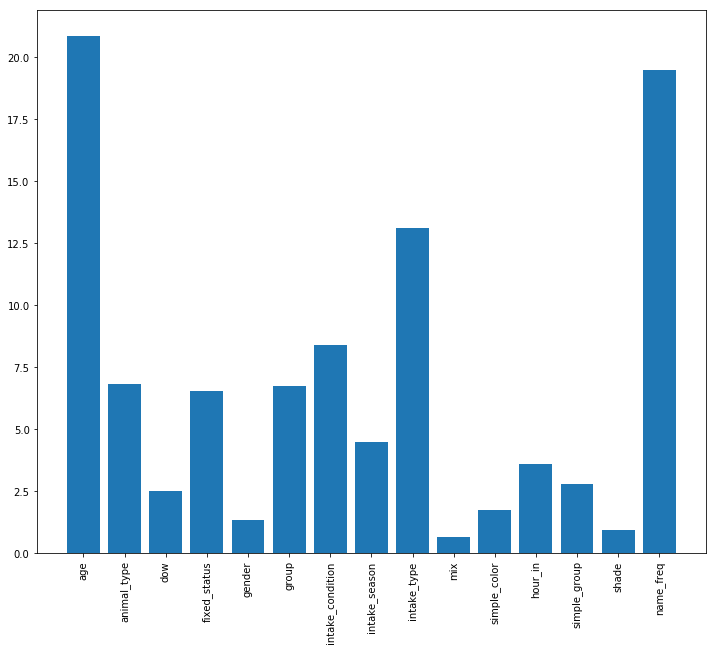

In [157]:
plt.figure(figsize=(12, 10))
plt.bar(X_train.columns, cat_boost.feature_importances_)
plt.xticks(rotation=90)

## Remove features with low importance and re-run model

In [232]:
X = X.drop(labels=['dow', 'gender', 'mix', 'simple_color', 'simple_group', 'shade'], axis=1)

In [237]:
pickle.dump(X, open('features.pkl', 'wb'))
pickle.dump(y, open('response.pkl', 'wb'))

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [235]:
X_train.columns.values

array(['age', 'animal_type', 'fixed_status', 'group', 'intake_condition',
       'intake_season', 'intake_type', 'hour_in', 'name_freq'],
      dtype=object)

In [236]:
cat_boost_reduce = CatBoostClassifier(cat_features = [1, 2, 3, 4, 5, 6], depth=8, learning_rate = .023,
                                      loss_function='MultiClass', n_estimators=800, one_hot_max_size=24)

reduced_scores = scores = cross_val_score(cat_boost_reduce, X_train, y_train, cv=3,
                                          n_jobs=-1, scoring='roc_auc')

print(reduced_scores)

[0.77666796 0.77952024 0.778683  ]


In [238]:
cat_boost_reduce.fit(X_train, y_train)

0:	learn: -0.6884471	total: 91.8ms	remaining: 1m 13s
1:	learn: -0.6839638	total: 177ms	remaining: 1m 10s
2:	learn: -0.6796472	total: 257ms	remaining: 1m 8s
3:	learn: -0.6755627	total: 345ms	remaining: 1m 8s
4:	learn: -0.6716262	total: 431ms	remaining: 1m 8s
5:	learn: -0.6679734	total: 522ms	remaining: 1m 9s
6:	learn: -0.6641747	total: 624ms	remaining: 1m 10s
7:	learn: -0.6606324	total: 714ms	remaining: 1m 10s
8:	learn: -0.6572148	total: 801ms	remaining: 1m 10s
9:	learn: -0.6539051	total: 896ms	remaining: 1m 10s
10:	learn: -0.6506541	total: 1000ms	remaining: 1m 11s
11:	learn: -0.6477622	total: 1.09s	remaining: 1m 11s
12:	learn: -0.6450180	total: 1.19s	remaining: 1m 11s
13:	learn: -0.6421078	total: 1.27s	remaining: 1m 11s
14:	learn: -0.6394184	total: 1.36s	remaining: 1m 11s
15:	learn: -0.6367090	total: 1.45s	remaining: 1m 11s
16:	learn: -0.6342075	total: 1.53s	remaining: 1m 10s
17:	learn: -0.6317299	total: 1.62s	remaining: 1m 10s
18:	learn: -0.6293279	total: 1.71s	remaining: 1m 10s
19:	l

159:	learn: -0.5580239	total: 13.3s	remaining: 53.2s
160:	learn: -0.5579722	total: 13.4s	remaining: 53.1s
161:	learn: -0.5578940	total: 13.5s	remaining: 53.1s
162:	learn: -0.5578446	total: 13.6s	remaining: 53s
163:	learn: -0.5577904	total: 13.6s	remaining: 52.9s
164:	learn: -0.5577247	total: 13.7s	remaining: 52.8s
165:	learn: -0.5576545	total: 13.8s	remaining: 52.8s
166:	learn: -0.5575961	total: 13.9s	remaining: 52.7s
167:	learn: -0.5575443	total: 14s	remaining: 52.6s
168:	learn: -0.5574417	total: 14.1s	remaining: 52.5s
169:	learn: -0.5573778	total: 14.2s	remaining: 52.5s
170:	learn: -0.5572531	total: 14.2s	remaining: 52.4s
171:	learn: -0.5571488	total: 14.3s	remaining: 52.3s
172:	learn: -0.5571102	total: 14.4s	remaining: 52.2s
173:	learn: -0.5570360	total: 14.5s	remaining: 52.1s
174:	learn: -0.5569733	total: 14.6s	remaining: 52.1s
175:	learn: -0.5569257	total: 14.7s	remaining: 52s
176:	learn: -0.5569239	total: 14.7s	remaining: 51.9s
177:	learn: -0.5568314	total: 14.8s	remaining: 51.8s

316:	learn: -0.5507464	total: 26.5s	remaining: 40.4s
317:	learn: -0.5507201	total: 26.6s	remaining: 40.3s
318:	learn: -0.5506779	total: 26.7s	remaining: 40.2s
319:	learn: -0.5506512	total: 26.8s	remaining: 40.1s
320:	learn: -0.5506178	total: 26.9s	remaining: 40.1s
321:	learn: -0.5505983	total: 26.9s	remaining: 40s
322:	learn: -0.5505850	total: 27s	remaining: 39.9s
323:	learn: -0.5505269	total: 27.1s	remaining: 39.8s
324:	learn: -0.5505224	total: 27.1s	remaining: 39.7s
325:	learn: -0.5504857	total: 27.2s	remaining: 39.6s
326:	learn: -0.5504797	total: 27.3s	remaining: 39.5s
327:	learn: -0.5504520	total: 27.4s	remaining: 39.4s
328:	learn: -0.5503588	total: 27.5s	remaining: 39.3s
329:	learn: -0.5503132	total: 27.5s	remaining: 39.2s
330:	learn: -0.5502396	total: 27.6s	remaining: 39.1s
331:	learn: -0.5502381	total: 27.7s	remaining: 39s
332:	learn: -0.5502127	total: 27.8s	remaining: 38.9s
333:	learn: -0.5501659	total: 27.8s	remaining: 38.8s
334:	learn: -0.5501109	total: 27.9s	remaining: 38.8s

472:	learn: -0.5462922	total: 38.9s	remaining: 26.9s
473:	learn: -0.5462434	total: 39s	remaining: 26.8s
474:	learn: -0.5461948	total: 39s	remaining: 26.7s
475:	learn: -0.5461822	total: 39.1s	remaining: 26.6s
476:	learn: -0.5461404	total: 39.2s	remaining: 26.6s
477:	learn: -0.5460967	total: 39.3s	remaining: 26.5s
478:	learn: -0.5460839	total: 39.4s	remaining: 26.4s
479:	learn: -0.5460489	total: 39.5s	remaining: 26.3s
480:	learn: -0.5459954	total: 39.5s	remaining: 26.2s
481:	learn: -0.5459932	total: 39.6s	remaining: 26.1s
482:	learn: -0.5459903	total: 39.7s	remaining: 26s
483:	learn: -0.5459772	total: 39.7s	remaining: 25.9s
484:	learn: -0.5459167	total: 39.8s	remaining: 25.9s
485:	learn: -0.5458602	total: 39.9s	remaining: 25.8s
486:	learn: -0.5458601	total: 40s	remaining: 25.7s
487:	learn: -0.5458372	total: 40s	remaining: 25.6s
488:	learn: -0.5458364	total: 40.1s	remaining: 25.5s
489:	learn: -0.5458140	total: 40.2s	remaining: 25.4s
490:	learn: -0.5458008	total: 40.3s	remaining: 25.3s
491

628:	learn: -0.5428365	total: 51.6s	remaining: 14s
629:	learn: -0.5428310	total: 51.7s	remaining: 13.9s
630:	learn: -0.5428145	total: 51.8s	remaining: 13.9s
631:	learn: -0.5427904	total: 51.8s	remaining: 13.8s
632:	learn: -0.5427700	total: 51.9s	remaining: 13.7s
633:	learn: -0.5427566	total: 52s	remaining: 13.6s
634:	learn: -0.5427359	total: 52.1s	remaining: 13.5s
635:	learn: -0.5427273	total: 52.2s	remaining: 13.5s
636:	learn: -0.5426935	total: 52.3s	remaining: 13.4s
637:	learn: -0.5426477	total: 52.4s	remaining: 13.3s
638:	learn: -0.5426250	total: 52.4s	remaining: 13.2s
639:	learn: -0.5426093	total: 52.5s	remaining: 13.1s
640:	learn: -0.5426025	total: 52.6s	remaining: 13s
641:	learn: -0.5426025	total: 52.7s	remaining: 13s
642:	learn: -0.5425597	total: 52.7s	remaining: 12.9s
643:	learn: -0.5425517	total: 52.8s	remaining: 12.8s
644:	learn: -0.5425336	total: 52.9s	remaining: 12.7s
645:	learn: -0.5425031	total: 53s	remaining: 12.6s
646:	learn: -0.5424998	total: 53.1s	remaining: 12.5s
647

787:	learn: -0.5398915	total: 1m 4s	remaining: 981ms
788:	learn: -0.5398742	total: 1m 4s	remaining: 899ms
789:	learn: -0.5398344	total: 1m 4s	remaining: 817ms
790:	learn: -0.5398258	total: 1m 4s	remaining: 735ms
791:	learn: -0.5398027	total: 1m 4s	remaining: 654ms
792:	learn: -0.5397977	total: 1m 4s	remaining: 572ms
793:	learn: -0.5397675	total: 1m 4s	remaining: 490ms
794:	learn: -0.5397558	total: 1m 4s	remaining: 409ms
795:	learn: -0.5397512	total: 1m 5s	remaining: 327ms
796:	learn: -0.5397510	total: 1m 5s	remaining: 245ms
797:	learn: -0.5397335	total: 1m 5s	remaining: 163ms
798:	learn: -0.5397164	total: 1m 5s	remaining: 81.7ms
799:	learn: -0.5396847	total: 1m 5s	remaining: 0us


In [244]:
y_preds = cat_boost_reduce.predict(X_test)

roc_auc_score(y_preds, y_test)

0.7121094595955413

## Catboost with hour+minute data

In [134]:
df_raw['outcome_type'] = df_raw['outcome_type'].astype(str)

In [135]:
X = df_raw.drop(labels=['outcome_type', 'given_name', 'days_in_shelter'], axis=1)
y = df_raw['outcome_type']

le = LabelEncoder()
le.fit(y)
y = le.transform(y.fillna('0'))

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [136]:
X_train.columns.values

array(['age', 'animal_type', 'dow', 'fixed_status', 'gender', 'group',
       'intake_condition', 'intake_season', 'intake_type', 'mix', 'name',
       'simple_color', 'simple_group', 'shade', 'name_freq', 'hour'],
      dtype=object)

In [137]:
cat_boost = CatBoostClassifier(cat_features=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                               depth=8, learning_rate = .023, loss_function='MultiClass',
                               n_estimators = 800, one_hot_max_size=24)

scores = cross_val_score(cat_boost, X_train, y_train, cv=3, n_jobs=-1, scoring='neg_log_loss')

In [138]:
scores

array([-0.87345825, -0.88395929, -0.87502304])

Does not add much to the model.